In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import featuretools as ft

color = sns.color_palette()
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

lgbr = LGBMRegressor()

In [91]:
#May be skipped! all data can be readed from Data/train_X, test_X, train_y

# Read and preprocessing the data
train_df = pd.read_csv("Data/train.csv", parse_dates=['date1'])
test_df = pd.read_csv("Data/test.csv", parse_dates=['date1'])
flat_df = pd.read_csv("Data/flat.csv")

print("Train rows and columns : ", train_df.shape)
print("Test rows and columns : ", test_df.shape)
print("flat rows and columns : ", flat_df.shape)

# remove unused in test data columns and convert data to days from 01/01/2015
train_df = train_df.drop(['start_square', 'plan_s', 'plan_m', 'plan_l', 'vid_0', 'vid_1', 'vid_2'], axis=1)
train_df['date1'] = (train_df['date1'] - pd.Timestamp('2015-01-01')).dt.days
test_df['date1'] = (test_df['date1'] - pd.Timestamp('2015-01-01')).dt.days

# getting unique values
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]

### Get the X and y variables for building model ###
train_X = train_df.drop(constant_df.col_name.tolist() + ["id", 'value'], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["id"], axis=1)
#train_y = np.log1p(train_df['value'].values)
train_y = train_df['value'].values

# so 'bulk_id' will be encoded as label and other features will OneHot
le_bulk = LabelEncoder()
le_bulk.fit(train_X['bulk_id'].append(test_X['bulk_id']))

# handling cat features
cat_features = train_X.columns[train_X.dtypes == 'object']

#train_X['bulk_id'] = le_bulk.transform(train_X['bulk_id'])
train_X = pd.get_dummies(train_X, columns=cat_features[1:])
#test_X['bulk_id'] = le_bulk.transform(test_X['bulk_id'])
test_X = pd.get_dummies(test_X, columns=cat_features[1:])

# save train and test data
#train_X.to_csv('Data/train_X.csv', index=False)
#test_X.to_csv('Data/test_X.csv', index=False)
#train_y.tofile('Data/train_y.csv', sep = ',')

Train rows and columns :  (8716, 56)
Test rows and columns :  (1770, 48)
flat rows and columns :  (111586, 51)


In [92]:
# read learning data
#train_X = pd.read_csv("Data/train_X.csv")
#test_X = pd.read_csv("Data/test_X.csv")
train_y = np.fromfile('Data/train_y.csv', sep = ',')

flat = pd.read_csv("Data/flat.csv")
price = pd.read_csv("Data/price.csv")

print("Flat rows and columns : ", flat.shape)
print("Price rows and columns : ", price.shape)

train_X.index.rename('index', inplace=True)
flat.index.rename('index', inplace=True)
price.index.rename('index', inplace=True)

Flat rows and columns :  (111586, 51)
Price rows and columns :  (647698, 5)


In [93]:
train_X.head()

,bulk_id,spalen,date1,price,mean_sq,mean_fl,month,month_cnt,Количество помещений,Площадь земельного участка,Детский сад,Школа,Поликлиника,ФОК,Кондиционирование,Вентлияция,Видеонаблюдение,Машиномест,Площадь пром. зоны в радиусе 500 м,Площадь зеленой зоны в радиусе 500 м,До Кремля,До ТТК(км),До Садового(км),До большой дороги на машине(км),До удобной авторазвязки на машине(км),До метро пешком(км),До промки(км),До парка(км),До парка пешком(км),Станций метро от кольца,Площадь двора,Курс,Cтавка по ипотеке,Вклады до 1 года,Вклады от 1 года до 3 лет,Вклады свыше 3 лет,Класс объекта_комфорт,Класс объекта_стандарт,Класс объекта_эконом,Огорожена территория_да,Огорожена территория_нет,Входные группы_да,Входные группы_нет,Автомойка_да,Автомойка_нет,Кладовые_да,Кладовые_нет,Колясочные_да,Колясочные_нет,Подземная парковка_да,Подземная парковка_нет,Двор без машин_да,Двор без машин_нет
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,FF3814A9-9F7D-E711-8530-00505688958B,1,1004,135633.913043,38.00,8,10,34,1983,17.0,345,825,0,0,1,1,0,1800,65357.0,25533.0,18.0,12.0,16.0,0.55,1.7,1.4,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0
1,FF3814A9-9F7D-E711-8530-00505688958B,2,1004,128492.419825,58.01,9,10,34,1983,17.0,345,825,0,0,1,1,0,1800,65357.0,25533.0,18.0,12.0,16.0,0.55,1.7,1.4,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0
2,FF3814A9-9F7D-E711-8530-00505688958B,0,1004,158237.634409,22.58,10,10,34,1983,17.0,345,825,0,0,1,1,0,1800,65357.0,25533.0,18.0,12.0,16.0,0.55,1.7,1.4,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0
3,FF3814A9-9F7D-E711-8530-00505688958B,3,1004,123250.000000,78.81,8,10,34,1983,17.0,345,825,0,0,1,1,0,1800,65357.0,25533.0,18.0,12.0,16.0,0.55,1.7,1.4,0.28,0.58,0.93,8.0,7640.0,57.698052,10.04,5.74,5.94,6.03,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0
4,FF3814A9-9F7D-E711-8530-00505688958B,1,1035,139420.634921,37.93,9,11,35,1983,17.0,345,825,0,0,1,1,0,1800,65357.0,25533.0,18.0,12.0,16.0,0.55,1.7,1.4,0.28,0.58,0.93,8.0,7640.0,58.926552,9.87,5.17,7.07,6.20,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0


In [83]:
price.head()

,id_flatwork,datefrom,dateto,pricem2,date_salestart
index,,,,,
0,E423E9CF-1416-E711-96FE-001EC9D5643C,2017-06-19 21:00:00,2017-12-29 21:00:00,90200.0,2017-04-18 21:00:00
1,EE9F1F73-01AF-E611-9FBE-001EC9D5643C,2017-02-13 21:00:00,2100-01-01 00:00:00,83000.0,2015-02-10 15:08:00
2,7DABC154-02AF-E611-9FBE-001EC9D5643C,2017-02-14 21:00:00,2017-11-01 21:00:00,106900.0,2016-04-22 08:17:00
3,F8CDA073-02AF-E611-9FBE-001EC9D5643C,2017-02-14 21:00:00,2017-09-07 21:00:00,85400.0,2016-04-22 08:17:00
4,77CEA073-02AF-E611-9FBE-001EC9D5643C,2017-02-14 21:00:00,2017-11-01 21:00:00,99600.0,2016-04-22 08:17:00


In [84]:
flat.head()

,id_sec,floor,spalen,stage_number,square,balcon,otdelka,plan0,id_bulk,section,date_settle,date_salestart,id_gk,id_flatwork,Класс объекта,Количество помещений,Огорожена территория,Площадь земельного участка,Входные группы,Детский сад,Школа,Поликлиника,ФОК,Спортивная площадка,Автомойка,Кладовые,Колясочные,Кондиционирование,Вентлияция,Лифт,Система мусоротведения,Видеонаблюдение,Подземная парковка,Двор без машин,Машиномест,Площадь пром. зоны в радиусе 500 м,Площадь зеленой зоны в радиусе 500 м,До Кремля,До ТТК(км),До Садового(км),До большой дороги на машине(км),До удобной авторазвязки на машине(км),До метро пешком(км),До промки(км),До парка(км),До парка пешком(км),Станций метро от кольца,Площадь двора,vid,sale,plan_size
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,846EA675-93FF-E411-8098-001EC9D56418,2,3.0,1,85.9,0,Не производится,3M-1*,4B3B6D6A-93FF-E411-8098-001EC9D56418,1,2017-03-15 21:00:00,2015-06-14 21:00:00,32671714-491B-E511-82D8-001EC9D5643C,8A11F41C-B3FF-E411-8098-001EC9D56418,комфорт,2284,нет,19.0,да,220,0,0,0,да,нет,да,да,3,1,1,контейнеры,1,нет,да,997,183441.0,0.0,18.0,13.0,16.0,1.2,3.9,0.96,0.06,0.61,1.1,10.0,14852.0,хороший,2016-07-22 21:00:00,L
1,846EA675-93FF-E411-8098-001EC9D56418,2,1.0,2,34.2,0,Не производится,1S-1*,4B3B6D6A-93FF-E411-8098-001EC9D56418,1,2017-03-15 21:00:00,2015-06-14 21:00:00,32671714-491B-E511-82D8-001EC9D5643C,9511F41C-B3FF-E411-8098-001EC9D56418,комфорт,2284,нет,19.0,да,220,0,0,0,да,нет,да,да,3,1,1,контейнеры,1,нет,да,997,183441.0,0.0,18.0,13.0,16.0,1.2,3.9,0.96,0.06,0.61,1.1,10.0,14852.0,хороший,2016-06-11 21:00:00,S
2,846EA675-93FF-E411-8098-001EC9D56418,2,1.0,3,33.7,0,Не производится,1S-2*,4B3B6D6A-93FF-E411-8098-001EC9D56418,1,2017-03-15 21:00:00,2015-06-14 21:00:00,32671714-491B-E511-82D8-001EC9D5643C,A011F41C-B3FF-E411-8098-001EC9D56418,комфорт,2284,нет,19.0,да,220,0,0,0,да,нет,да,да,3,1,1,контейнеры,1,нет,да,997,183441.0,0.0,18.0,13.0,16.0,1.2,3.9,0.96,0.06,0.61,1.1,10.0,14852.0,хороший,2015-08-29 21:00:00,S
3,846EA675-93FF-E411-8098-001EC9D56418,2,0.0,4,22.4,0,Не производится,S-1*,4B3B6D6A-93FF-E411-8098-001EC9D56418,1,2017-03-15 21:00:00,2015-06-14 21:00:00,32671714-491B-E511-82D8-001EC9D5643C,AB11F41C-B3FF-E411-8098-001EC9D56418,комфорт,2284,нет,19.0,да,220,0,0,0,да,нет,да,да,3,1,1,контейнеры,1,нет,да,997,183441.0,0.0,18.0,13.0,16.0,1.2,3.9,0.96,0.06,0.61,1.1,10.0,14852.0,хороший,2015-06-29 21:00:00,S
4,846EA675-93FF-E411-8098-001EC9D56418,2,2.0,5,57.5,0,Не производится,2M-1,4B3B6D6A-93FF-E411-8098-001EC9D56418,1,2017-03-15 21:00:00,2015-06-14 21:00:00,32671714-491B-E511-82D8-001EC9D5643C,B611F41C-B3FF-E411-8098-001EC9D56418,комфорт,2284,нет,19.0,да,220,0,0,0,да,нет,да,да,3,1,1,контейнеры,1,нет,да,997,183441.0,0.0,18.0,13.0,16.0,1.2,3.9,0.96,0.06,0.61,1.1,10.0,14852.0,хороший,2015-08-16 21:00:00,M


In [99]:
es = ft.EntitySet(id='bulks')

es = es.entity_from_dataframe(r'bulks', train_X, make_index= True, index = 'bulk_index')
es = es.entity_from_dataframe(entity_id="flats", dataframe=flat, index = 'id_flatwork')
es = es.entity_from_dataframe(entity_id="prices", dataframe=price, make_index= True, index = 'price_index')

In [106]:
es

Entityset: bulks
  Entities:
    bulks [Rows: 8716, Columns: 54]
    flats [Rows: 111586, Columns: 51]
    prices [Rows: 647698, Columns: 6]
  Relationships:
    bulks.bulk_id -> flats.id_flatwork

In [105]:
flats_and_bulks = ft.Relationship(es['flats']['id_flatwork'], es['bulks']['bulk_id'])
#flats_and_price = ft.Relationship(es['flats']['id_flatwork'], es['price']['id_flatwork'])
es = es.add_relationship(flats_and_bulks)
#es = es.add_relationship(flats_and_price)

2018-07-03 16:58:46,729 featuretools.entityset - WARNING    Not adding duplicate relationship: <Relationship: bulks.bulk_id -> flats.id_flatwork>


In [108]:
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_entity = 'bulks', 
                                 agg_primitives = ['mean', 'max', 'percent_true'],
                                 trans_primitives = ['subtract'],
                                verbose= 2,
                                n_jobs=3)

KeyboardInterrupt: 

In [4]:
%%time
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.02,
        "bagging_fraction" : 0.95,
        "feature_fraction" : 0.3,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 3000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

# Kfold on 5 splits
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.

# some predictions are negative, replace them by 0
pred_test_full[pred_test_full < 0] = 0

# Making a submission file #
sub_df = pd.DataFrame({"id":range(len(pred_test))})
sub_df["value"] = pred_test
#sub_df.to_csv("baseline_lgb.csv", index=False)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 254.051
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 246.042
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 252.663
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 242.235
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 248.545
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 237.876
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 257.743
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 249.465
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 226.196
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 218.453
Wall time: 7.2 s


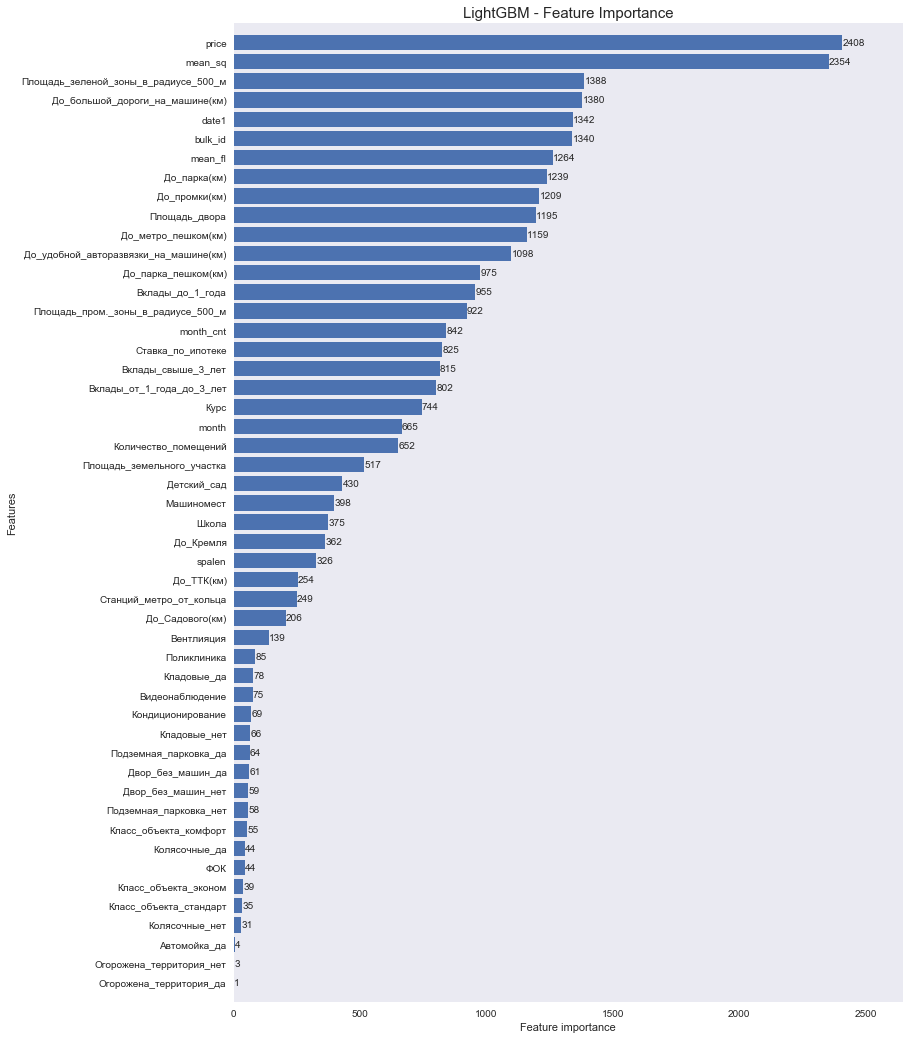

In [13]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=-1, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()